<a href="https://colab.research.google.com/github/lapshinaaa/homework_DeepLearning/blob/main/homework_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-12 06:03:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [       <=>          ] 201.24M  38.3MB/s    in 5.6s    

2023-10-12 06:03:58 (35.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
# checking for any missing values:
df.isnull().values.any() # output: False -> no missing values found

False

In [6]:
from sklearn.preprocessing import StandardScaler

# creating an instance of a Scaler
scaler = StandardScaler()

# scaling all the numerical features:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# taking a look at the results:
X_train_df = pd.DataFrame(X_train)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.078786,0.391566,1.826962,0.466361,-0.476621,-0.275266,-1.551924,-1.311105,0.389093,-0.665402,...,-0.084995,0.106413,0.144257,-0.236180,0.047430,-0.355855,0.544084,-0.470477,-0.255366,0.042637
1,0.879511,0.332631,1.748961,0.723345,-0.166769,-1.189729,0.764797,0.109714,1.422683,0.416934,...,-0.314004,0.304413,-0.068758,0.053729,-0.634467,-0.435794,0.556059,0.570861,0.209341,1.161118
2,1.245515,0.592771,1.337550,0.752153,-0.002899,-0.699856,-0.061323,-0.069912,1.167910,-0.073176,...,-0.395974,0.565220,-0.758259,-0.282931,-0.026058,0.223918,-0.508889,-0.338081,0.107828,-0.090122
3,0.799787,-0.061214,0.784000,0.089197,0.327463,-1.297159,0.509977,-1.073557,-0.015553,-1.262565,...,0.586855,-0.562444,-0.479423,-0.890199,-0.796124,0.568335,-0.262505,0.409924,0.973205,0.795200
4,1.247663,0.793377,1.657449,0.449177,-0.408652,-0.564673,-0.692545,-0.952369,0.843389,-0.143557,...,-0.181284,0.097564,0.192974,-0.585048,-0.113758,-0.219524,0.448546,0.258400,0.194381,1.244057


In [7]:
def set_random_seed(seed):
    # setting random seed for PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # disabling the in-built cudnn
                                           # auto-tuner for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # setting random seed for NumPy
    np.random.seed(seed)

    # setting random seed for Python 'random' module
    random.seed(seed)

**Sourse of information regarding the added line with disabling the in-built cudnn for better reproducibility: ** https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936

In [8]:
set_random_seed(42)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# creating an instance of a Ridge regressor and training the model
model = Ridge()
model.fit(X_train, y_train)

# making predictions on the test data:
y_pred = model.predict(X_test)

# calculating RMSE for the results and printing it out
rmse_for_model = mean_squared_error(y_pred, y_test, squared=False)
print(f'RMSE for the trained Ridge model is: {rmse_for_model}')

RMSE for the trained Ridge model is: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
# calculating the mean:
y_mean = y_train.mean() # this mean represents the average release year of the songs in the training dataset
constant_predictions = [y_mean] * len(y_test)

# calculating and printing out the results
best_rmse_metric = mean_squared_error(constant_predictions, y_test, squared=False)
print(f'RMSE for the constant prediction is: {best_rmse_metric}')

RMSE for the constant prediction is: 10.85246390513634


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
# creating a model with only one Linear layer (I'll be using the first one
# of the methods from the previous seminar)

class LinearModel(nn.Module):
  """Simple Class for creating
    Linear Regression models"""

  # constructor for the class
  def __init__(self, input_size, output_size):
    super(LinearModel, self).__init__()
    self.linear = nn.Linear(input_size, output_size)

  # method for forward pass:
  def forward(self, x):
    return self.linear(x)

linear_regression_model = LinearModel(90, 1)

In [12]:
linear_regression_model.to(device)

LinearModel(
  (linear): Linear(in_features=90, out_features=1, bias=True)
)

In [13]:
set_random_seed(34)

In [14]:
from torch.utils.data import DataLoader, TensorDataset

# combining train and test data for further exploitation
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# Initializing data loaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=1)

In [16]:
# checking of we receive random batches correctly
batch = next(iter(train_dataloader))

print(f"Sample:\n{batch}")

Sample:
[tensor([[-5.8495e-01, -1.4995e+00,  2.3344e+00,  1.3688e+00, -5.8541e-02,
          1.3828e+00, -7.8841e-01, -1.1885e-02,  8.9290e-01, -3.2816e-01,
          1.4733e+00,  1.7191e+00, -5.4144e-01,  1.3280e+00, -2.0998e-01,
          1.0503e-01, -3.4619e-01,  1.3475e-01, -2.7433e-02, -2.3260e-01,
         -1.6652e-02,  7.1251e-02,  1.7566e-02,  1.2945e+00,  9.7087e-01,
          1.9435e+00,  1.6528e-02, -1.3162e+00,  1.5476e-01,  6.7123e-01,
          1.2632e+00, -4.4261e-01,  3.5066e-01,  4.4591e-01, -4.6077e-01,
          5.1937e-01,  6.6235e-01, -6.9599e-01, -9.0676e-01,  6.3399e-01,
          9.2402e-01, -1.0067e+00, -2.2540e-01, -1.2123e-01, -1.6627e+00,
          3.7322e-01, -1.3145e+00,  3.5805e-01, -5.3309e-01,  1.0985e+00,
          1.9015e-01, -3.7133e-01, -7.5016e-01, -5.1870e-01, -3.2222e-01,
          3.8927e-01, -2.3542e-01, -4.3476e-01,  3.5412e-01,  3.7211e-01,
          7.0002e-01,  1.5053e+00,  1.6615e-01, -6.4300e-01, -6.8663e-01,
         -2.1340e-02,  1.0757

In [17]:
# functions for calculating losses
def root_mean_squared_error(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    mean_squared_error = torch.mean(squared_error)
    return torch.sqrt(mean_squared_error)

# def mean_squared_error(y_pred, y_true):
#     squared_error = (y_pred - y_true) ** 2
#     mean_squared_error = torch.mean(squared_error)
#     return mean_squared_error

**QUICK NOTE FOR THOSE CHECKING THE TASK BELOW:** The functions ".train()" and ".eval()" are typically used when you're working with models that have components such as dropout or batch normalization. In the provided code below, the model doesn't contain dropout layers or batch normalization, therefore it might not be necessary to call model.train() and model.eval() explicitly.

In [ ]:
num_epochs = 10
learning_rate = 0.01

# storing losses for plotting the data afterwards
train_losses = []
val_losses_track = []

# loop for training a linear regression model
for epoch in range(num_epochs):
    # model.train()
    for x_train, y_train in tqdm(train_dataloader):  # taking a batch from a dataloader
        x_train = x_train.to(device, dtype=torch.float32)  # converting input data to float32
        y_train = y_train.to(device, dtype=torch.float32)  # converting target data to float32
        y_pred = linear_regression_model(x_train)  # forward pass
        loss = root_mean_squared_error(y_pred, y_train)  # calculating RMSE

        # doing a backward pass:
        loss.backward()

        # manual implementation of an optimizer (SGD):
        with torch.no_grad():
            for parameter in linear_regression_model.parameters():
            #    torch.nn.utils.clip_grad_norm_(linear_regression_model.parameters(), max_norm=1.0)
                parameter.data = parameter.data - learning_rate * parameter.grad
                parameter.grad.zero_()  # zeroing out gradients

        train_losses.append(loss.item())

    # evaluating the model during each epoch (according to the task):
    # model.eval()
    with torch.no_grad():
        val_losses = []
        for x_val, y_val in tqdm(val_dataloader):  # taking a batch from a dataloader
            x_val = x_val.to(device, dtype=torch.float32)  # converting input data to float32
            y_val = y_val.to(device, dtype=torch.float32)  # converting target data to float32
            y_pred_val = linear_regression_model(x_val)
            loss = root_mean_squared_error(y_pred_val, y_val)
            val_losses.append(loss.cpu().numpy())  # appending loss values
            val_losses_track.append(loss.cpu().numpy())

    print(f"Epoch: {epoch + 1}, loss: {np.mean(val_losses)}")

  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 1, loss: 1534.830078125


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 2, loss: 1070.455810546875


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 3, loss: 606.3926391601562


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 4, loss: 142.23291015625


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 5, loss: 8.527359962463379


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 6, loss: 8.548995018005371


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 7, loss: 8.536373138427734


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 8, loss: 8.566433906555176


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 9, loss: 8.565329551696777


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 10, loss: 8.532962799072266


**ATTENTION!** While completing the task above, I've encountered the following error multiple times: "mat1 and mat2 must have the same dtype". Editing the custom RMSE function as well as converting the data to float32 helped to solve it. The solution was found here: https://stackoverflow.com/questions/75102134/mat1-and-mat2-must-have-the-same-dtype

In [18]:
from scipy.interpolate import make_interp_spline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

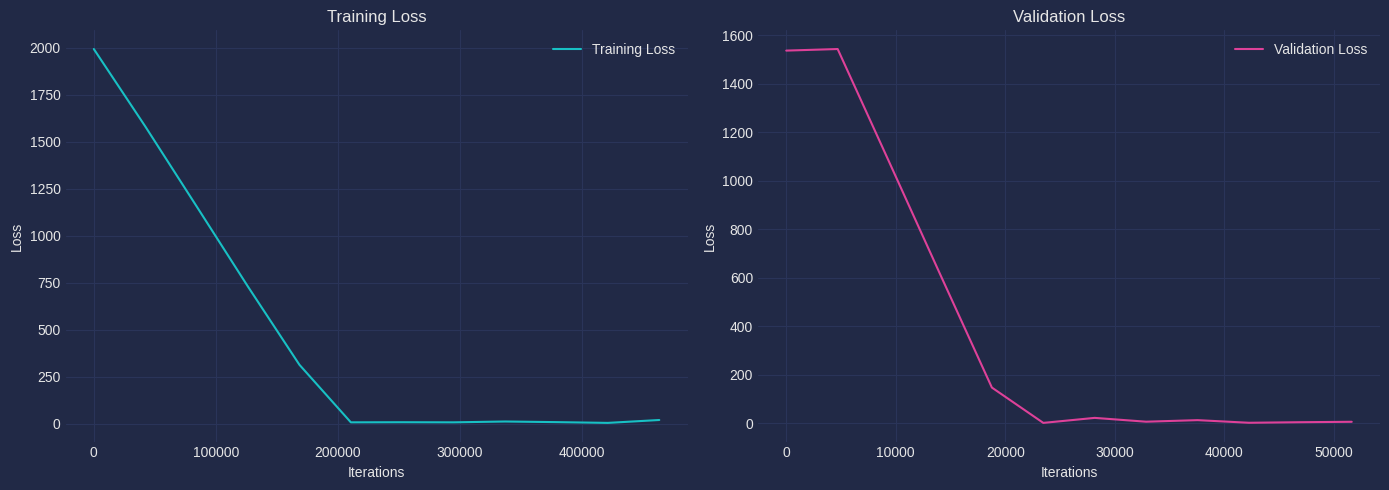

In [ ]:
# each batch represents one iteration
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# making a curve appear smoother
num_smooth_points = 12

# creating smoothed curves for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# plotting a train loss curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss")

# plotting a validation loss curve
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss")


plt.tight_layout()
plt.show()

**Credits:** the styles for the plots were found on: https://github.com/dhaitz/matplotlib-stylesheets#pitaya-smoothie-dark

**To make a line appear smoother I used an approach mentioned here:** https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

**The first experiment:**

In [19]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [20]:
# preprocessing data using MinMax scaler:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train)
X_test_normalized = min_max_scaler.transform(X_test)

**Taking a look at the normalized data, including the normalized target:**

In [21]:
X_train_normalized_df = pd.DataFrame(X_train_normalized)
X_train_normalized_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.800293,0.497205,0.599629,0.367203,0.370583,0.340733,0.452564,0.339147,0.492380,0.384046,...,0.352499,0.490087,0.372344,0.652636,0.569286,0.460524,0.613453,0.334855,0.500338,0.348738
1,0.780177,0.492987,0.595220,0.376664,0.386532,0.282509,0.546232,0.402802,0.532466,0.453276,...,0.346752,0.494001,0.367177,0.658401,0.550999,0.459186,0.613745,0.354687,0.506122,0.375569
2,0.817124,0.511606,0.571964,0.377724,0.394968,0.313699,0.512831,0.394755,0.522585,0.421927,...,0.344695,0.499157,0.350453,0.651706,0.567316,0.470228,0.587814,0.337376,0.504859,0.345553
3,0.772129,0.464800,0.540674,0.353319,0.411973,0.275668,0.535929,0.349790,0.476686,0.345849,...,0.369357,0.476865,0.357216,0.639630,0.546663,0.475993,0.593813,0.351622,0.515629,0.366791
4,0.817341,0.525963,0.590047,0.366571,0.374082,0.322307,0.487309,0.355219,0.509999,0.417425,...,0.350082,0.489912,0.373525,0.645698,0.564964,0.462806,0.611127,0.348736,0.505936,0.377559


In [22]:
# class RMSE for criterion usage
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = nn.functional.mse_loss(y_pred, y_true)
        rmse = torch.sqrt(mse)
        return rmse

In [23]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR

# combining train and test data for further exploitation
                          # and initializing data loaders:
train_set = TensorDataset(torch.from_numpy(X_train_normalized),
                          torch.from_numpy(y_train.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=1)

test_set = TensorDataset(torch.from_numpy(X_test_normalized),
                         torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=1)

model = LinearModel(90, 1)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03) # using SGD with
                                                   # a 0.03 learning rate
criterion = RMSELoss()  # using RMSE as criterion

In [24]:
set_random_seed(34)

In [25]:
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs: int):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        num_epochs - number of epochs
    """
    train_losses = []
    val_losses_track = [] # for plotting the results

    for epoch in range(num_epochs):
    #  model.train() # setting the model to training mode (necessary in certain cases)

      for x_train, y_train in tqdm(train_loader):
        x_train = x_train.to(device, dtype=torch.float32)
        y_train = y_train.to(device, dtype=torch.float32)

        y_pred = model(x_train)
        loss = criterion(y_pred, y_train) # calculating RMSE
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item()) # storing losses on train data

      if test_loader is not None: # validating during training
     #   model.eval() # setting the model to evaluation mode
        with torch.no_grad():
          val_losses = []
          for x_val, y_val in tqdm(test_loader):
            x_val = x_val.to(device, dtype=torch.float32)
            y_val = y_val.to(device, dtype=torch.float32)
            y_pred_val = model(x_val)
            loss = criterion(y_pred_val, y_val)
            val_losses.append(loss.cpu().numpy())
            val_losses_track.append(loss.cpu().numpy())

        print(f"Epoch: {epoch + 1}, loss: {np.mean(val_losses)}")

    return train_losses, val_losses_track


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval() # setting the model to evaluation mode
    predicts = [] # storing predictions

    with torch.no_grad():
      for x_test, _ in test_loader: # we'll only need x_test for making predictions
        x_test = x_test.to(device, dtype=torch.float32)
       # y_test = y_test.to(device, dtype=torch.float32)

        y_pred = model(x_test) # making predictions
        predicts.extend(y_pred.cpu().numpy())

    # converting the list of predictions to a NumPy array and then to tensor
    predicts = np.array(predicts)
    predicts = torch.tensor(predicts)

    return predicts

In [26]:
# getting results for the first experimental model
num_epochs = 10
train_losses, val_losses_track = train(model, optimizer, criterion, train_loader, test_loader, num_epochs)

  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 1, loss: 13.138007164001465


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 2, loss: 12.325328826904297


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 3, loss: 11.932549476623535


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 4, loss: 11.594752311706543


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 5, loss: 11.327558517456055


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 6, loss: 11.15008544921875


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 7, loss: 11.097380638122559


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 8, loss: 10.878507614135742


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 9, loss: 10.823166847229004


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 10, loss: 10.892905235290527


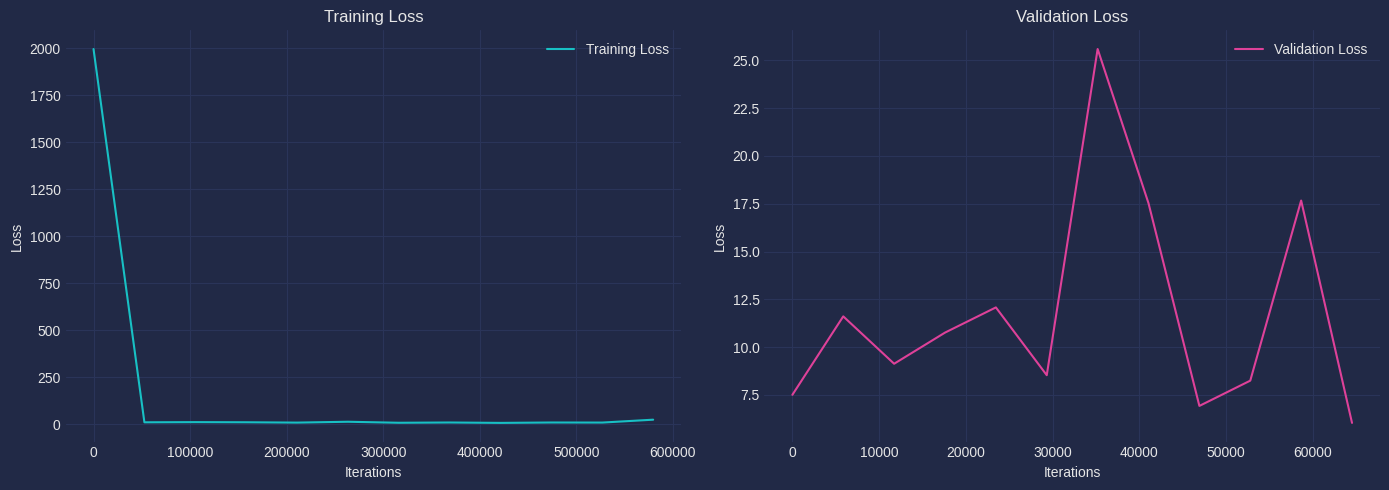

In [27]:
# each batch represents one iteration
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# making a curve appear smoother
num_smooth_points = 12

# creating smoothed curves for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# plotting a train loss curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss")

# plotting a validation loss curve
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss")


plt.tight_layout()
plt.show()

In [28]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

**The second experiment:**

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
# creating an instance of a StandardScaler
scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
set_random_seed(36)

In [ ]:
# combining train and test data for further exploitation
                          # and initializing data loaders:
train_set = TensorDataset(torch.from_numpy(X_train_normalized),
                          torch.from_numpy(y_train.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=1)

test_set = TensorDataset(torch.from_numpy(X_test_normalized),
                         torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=1)

second_model = LinearModel(90, 1)
second_model.to(device)
second_optimizer = optim.Adam(second_model.parameters(), lr=0.01) # using Adam optimizer
                                                          # with 0.01 initially
criterion = RMSELoss()  # using RMSE as criterion

In [ ]:
# getting results for the second experimental model
num_epochs = 10
train_losses, val_losses_track = train(second_model, second_optimizer, criterion, train_loader, test_loader, num_epochs)

  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 1, loss: 12.012091636657715


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 2, loss: 11.305838584899902


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 3, loss: 10.891977310180664


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 4, loss: 10.646373748779297


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 5, loss: 10.475345611572266


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 6, loss: 10.381629943847656


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 7, loss: 10.247417449951172


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 8, loss: 10.1395263671875


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 9, loss: 10.065930366516113


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 10, loss: 10.067771911621094


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 11, loss: 9.94542407989502


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 12, loss: 9.899218559265137


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 13, loss: 10.308601379394531


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 14, loss: 9.823705673217773


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 15, loss: 9.791476249694824


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 16, loss: 9.762078285217285


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 17, loss: 9.741307258605957


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 18, loss: 9.717984199523926


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 19, loss: 9.715536117553711


  0%|          | 0/92743 [00:00<?, ?it/s]

  0%|          | 0/10326 [00:00<?, ?it/s]

Epoch: 20, loss: 9.680569648742676


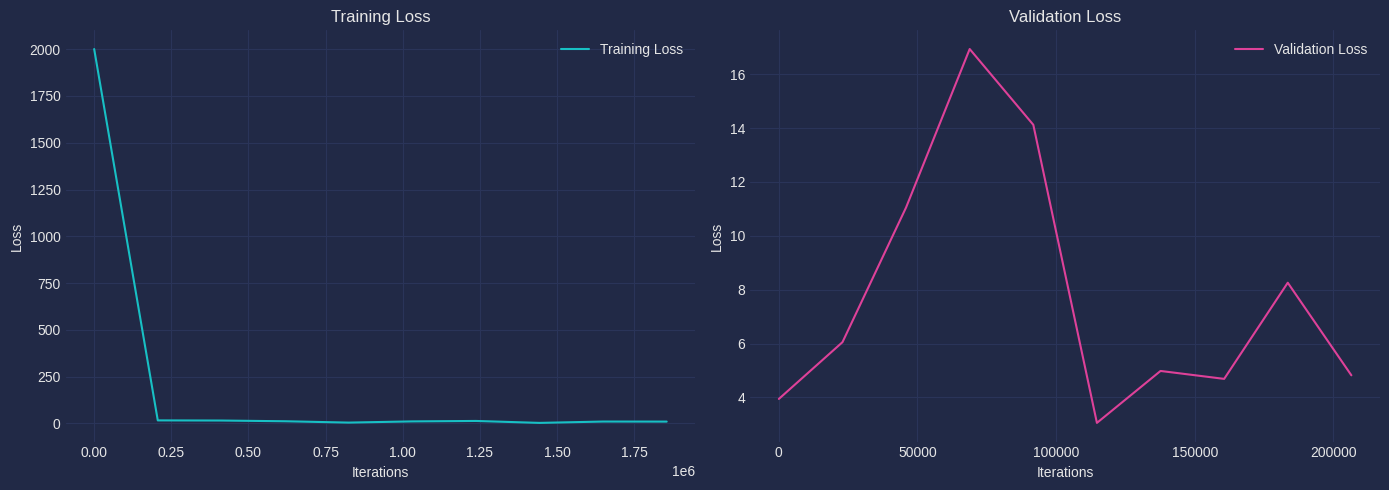

In [ ]:
# each batch represents one iteration
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# making a curve appear smoother
num_smooth_points = 10

# creating smoothed curves for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# plotting a train loss curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss")

# plotting a validation loss curve
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss")


plt.tight_layout()
plt.show()

**The third experiment:**

In [40]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [41]:
# creating an instance of a StandardScaler
scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# normalizing the target variable
y_train_normalized = target_scaler.fit_transform(y_train.reshape(-1, 1))

**Modified function for when the target variable is normalized:**

In [42]:
def train(model, optimizer, train_criterion, eval_criterion, train_loader, test_loader, num_epochs: int):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        train_criterion - loss function from torch.nn (MSE)
        eval_criterion - loss function (RMSE)
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        num_epochs - number of epochs
    """
    train_losses = []
    val_losses_track = [] # for plotting the results

    for epoch in range(num_epochs):
      model.train() # setting the model to training mode (necessary in certain cases)

      for x_train, y_train in tqdm(train_loader):
        x_train = x_train.to(device, dtype=torch.float32)
        y_train = y_train.to(device, dtype=torch.float32)

        y_pred = model(x_train)
        loss = train_criterion(y_pred, y_train) # calculating RMSE
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item()) # storing losses on train data

      if test_loader is not None: # validating during training
        model.eval() # setting the model to evaluation mode
        with torch.no_grad():
          val_losses = []
          for x_val, y_val in tqdm(test_loader):
            x_val = x_val.to(device, dtype=torch.float32)
            y_val = y_val.to(device, dtype=torch.float32)
            y_pred_val = model(x_val)

            # inverse transformation of the target variable to calculate RMSE
            y_pred_val = target_scaler.inverse_transform(y_pred_val.cpu().numpy().reshape(-1, 1))
            y_pred_val = torch.from_numpy(y_pred_val)

         #   print(y_pred_val)
          #  print(y_val)

            loss = eval_criterion(y_pred_val, y_val)
            val_losses.append(loss.cpu().numpy())
            val_losses_track.append(loss.cpu().numpy())

        print(f"Epoch: {epoch + 1}, loss: {np.mean(val_losses)}")

    return train_losses, val_losses_track


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval() # setting the model to evaluation mode
    predicts = [] # storing predictions

    with torch.no_grad():
      for x_test, _ in test_loader: # we'll only need x_test for making predictions
        x_test = x_test.to(device, dtype=torch.float32)
       # y_test = y_test.to(device, dtype=torch.float32)

        y_pred = model(x_test) # making predictions

        # inverse transformation of the predictions to the original scale
        y_pred = target_scaler.inverse_transform(y_pred)

        predicts.extend(y_pred.cpu().numpy())

    # converting the list of predictions to a NumPy array and then to tensor
    predicts = np.array(predicts)
    predicts = torch.tensor(predicts)

    return predicts

In [43]:
# defining criterion for training and evaluation
train_criterion = nn.MSELoss()
evaluation_criterion = RMSELoss()

In [44]:
set_random_seed(36)

In [45]:
# combining train and test data for further exploitation
                          # and initializing data loaders:
train_set = TensorDataset(torch.from_numpy(X_train_normalized),
                          torch.from_numpy(y_train_normalized.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=1)

test_set = TensorDataset(torch.from_numpy(X_test_normalized),
                         torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=10, shuffle=False, num_workers=1)

model_third = LinearModel(90, 1)
model_third.to(device)
third_optimizer = optim.Adam(model_third.parameters(), lr=0.01) # using Adam with
                                                   # a 0.01 learning rate

In [46]:
# getting results for the third experimental model
num_epochs = 3
train_losses, val_losses_track = train(model_third, third_optimizer, train_criterion, evaluation_criterion, train_loader, test_loader, num_epochs)

  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 1, loss: 8.668919563293457


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 2, loss: 11.2576265335083


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 3, loss: 8.356257438659668


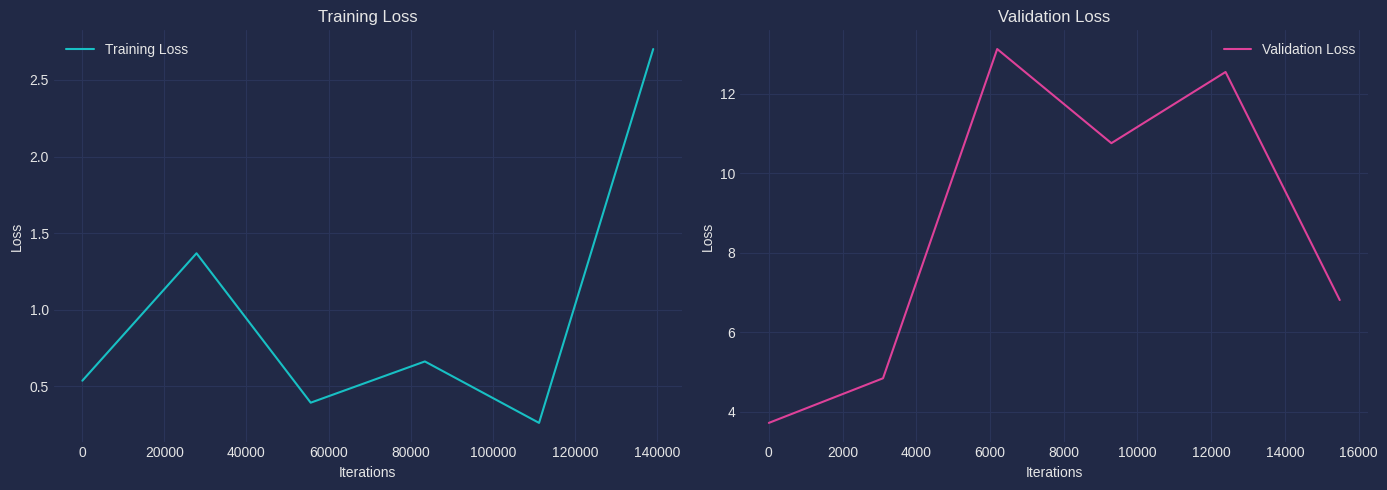

In [48]:
# each batch represents one iteration
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# making a curve appear smoother
num_smooth_points = 6

# creating smoothed curves for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# plotting a train loss curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss")

# plotting a validation loss curve
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss")


plt.tight_layout()
plt.show()

**The fourth experiment:**

In [58]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [59]:
# creating an instance of a StandardScaler
scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# normalizing the target variable
y_train_normalized = target_scaler.fit_transform(y_train.reshape(-1, 1))

In [60]:
# defining criterion for training and evaluation
train_criterion = nn.MSELoss()
evaluation_criterion = RMSELoss()

In [61]:
set_random_seed(40)

In [62]:
# combining train and test data for further exploitation
                          # and initializing data loaders:
train_set = TensorDataset(torch.from_numpy(X_train_normalized),
                          torch.from_numpy(y_train_normalized.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=1)

test_set = TensorDataset(torch.from_numpy(X_test_normalized),
                         torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=1)

model_fourth = LinearModel(90, 1)
model_fourth.to(device)
fourth_optimizer = optim.SGD(model_fourth.parameters(), lr=0.01) # using SGD with
                                                   # a 0.01 learning rate

In [63]:
# getting results for the fourth experimental model
num_epochs = 5
train_losses, val_losses_track = train(model_fourth, fourth_optimizer, train_criterion, evaluation_criterion, train_loader, test_loader, num_epochs)

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch: 1, loss: 8.310545921325684


  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch: 2, loss: 8.637969970703125


  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch: 3, loss: 8.419951438903809


  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch: 4, loss: 8.5132474899292


  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch: 5, loss: 8.545333862304688


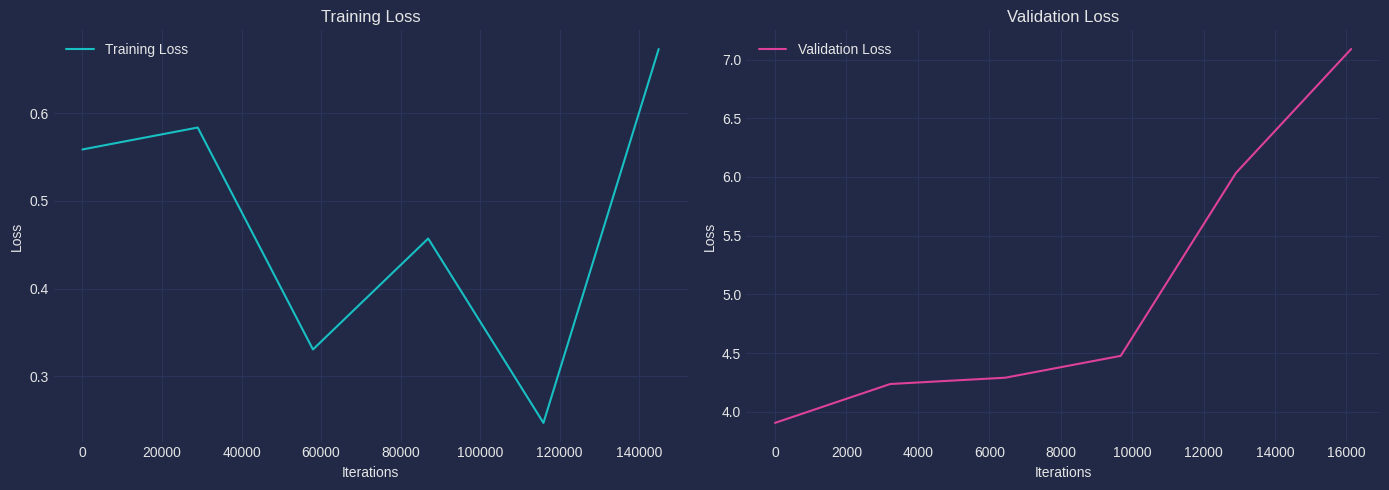

In [64]:
# each batch represents one iteration
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# making a curve appear smoother
num_smooth_points = 6

# creating smoothed curves for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# plotting a train loss curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss")

# plotting a validation loss curve
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss")


plt.tight_layout()
plt.show()

*As can be seen in graph above, already after the first epoch the model showed good results and its further training led to its overfitting and comparatively worsened performance.*

**The fifth experiment:**

In [73]:
# combining train and test data for further exploitation
                          # and initializing data loaders:
train_set = TensorDataset(torch.from_numpy(X_train_normalized),
                          torch.from_numpy(y_train_normalized.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=1)

test_set = TensorDataset(torch.from_numpy(X_test_normalized),
                         torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=1)

model_fifth = LinearModel(90, 1)
model_fifth.to(device)
fifth_optimizer = optim.Adam(model_fifth.parameters(), lr=0.001, weight_decay=1e-5) # using Adam with
                                                   # a 0.001 learning rate and weight decay

In [74]:
set_random_seed(47)

In [76]:
# getting results for the fifth experimental model
num_epochs = 4
train_losses, val_losses_track = train(model_fifth, fifth_optimizer, train_criterion, evaluation_criterion, train_loader, test_loader, num_epochs)

  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 1, loss: 7.793139457702637


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 2, loss: 8.152243614196777


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 3, loss: 7.879013538360596


  0%|          | 0/57965 [00:00<?, ?it/s]

  0%|          | 0/6454 [00:00<?, ?it/s]

Epoch: 4, loss: 7.795897483825684


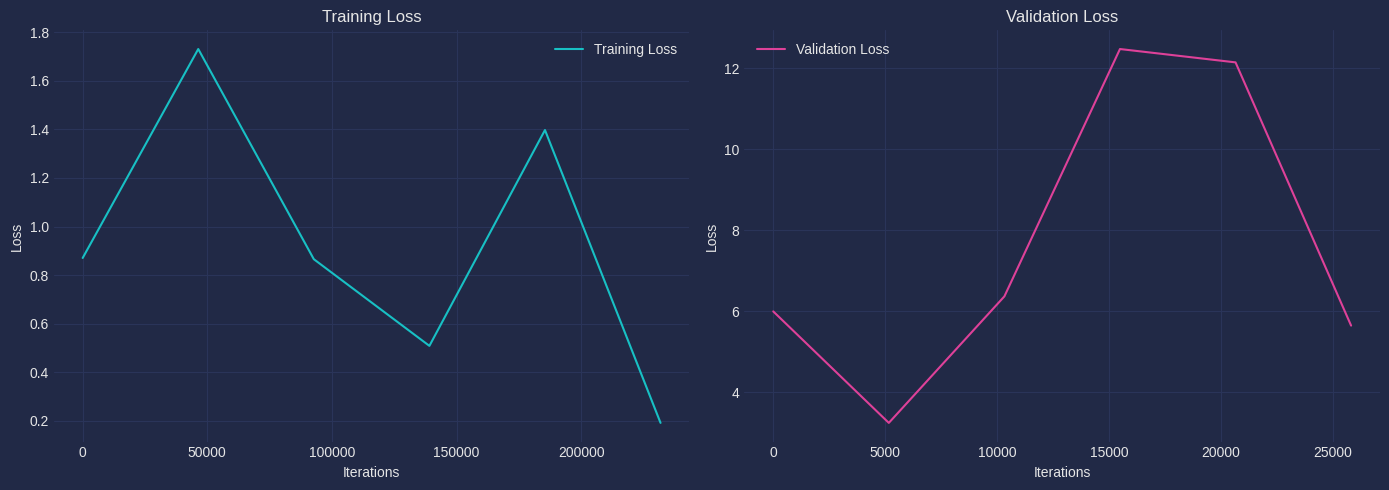

In [77]:
# each batch represents one iteration
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# making a curve appear smoother
num_smooth_points = 6

# creating smoothed curves for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# plotting a train loss curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss")

# plotting a validation loss curve
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss")


plt.tight_layout()
plt.show()

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Some general comments** regarding the performance of all of the models I've worked with as part of these tasks so far:
The fact that the first model improved from an initial RMSE of more than 1500 to 8.5 during the last epoch suggests that it was, presumably, able to learn and adapt well to the training data over time. The behavior of other models starting at an RMSE of 11 but staying around 9.5-10 can be influenced by various factors, such as hyperparameters, model architecture, and data characteristics. So I decided to experiment with that.

**# 1 experiment:**


*   MinMax Normalization
*   Default linear model (as in the previous task)
*   0.03 learning rate
*   Batch size = 8
*   10 epochs
*   Learning rate = 0.01

The best result: 10.82. The model performed well initially during the first few epochs. However, it then started slow down in weights update - hence, the quality remained steady, around 10-11. As can be seen on the graph above (#1 experiment), the validation loss is chaotic and exhibits significant fluctuations during training. To combat these issues, Adam optimizer (which will help with learning schedule) will be implemented instead of SGD. Also, MinMax data preprocessing will be replaced with a StandardScaler option (since the performance of the very first model was already good enough in the frame of this task).


**# 2 experiment:**


*   Different normalization - because the previous results were better
*   Adam optimizer
*   Batch size = 8 for better generalization
*   20 epochs to allow the model to found local optimum without getting stuck in other optima

The best result: 9.680. The result is still worse than the performance of the very first model. However, it is better than the previous one. 10 epochs allowed the model to search for the optimum for a longer period of time. The results on the validation set were pretty much chaotic (see graph #2 above), so more changes are to be made as part of further experiments. Adam optimizer shows a noticable imporvement in model's performance, therefore it will be used in further experiments. Since the results of the first (task 2) model were better, StandardScaler was used as part of the second experiment instead of MinMax.









**# 3 experiment:**

*   Batch size = 8
*   Fewer epochs (3) - to avoid overfitting
*   Adam optimizer (0.01 - initial learning rate)
*   Target variable experiments (normalization before training the model)

The best result: 8.35. This model showed the best performance of all of the models presented. There are only 3 epochs because already after the first one the model shows substantially good results, and further training thereof leads to it overfitting, which is not good. I kept using Adam optimizer (I already tried SGD, but no significant difference was spotted). The target variable was also normalized and then converted back to its original format for loss calculation - that helped improve the quality of the aforementioned model. The batch size is 8 (empirically, because everything that's larger than 32 is considered bad, but really small batches are extremely hard to work with time-wise).






**#4 experiment:**

*   Bigger batch size (16)
*   SGD optimizer with 0.01 initial learing rate
*   Number of epochs = 5

The best result: 8.31 (after the first epoch).
Everything else, compared to the previous experiment (see #3) remained the same. Only the number of epochs was increased to 5, along with the batch size - the local optimum was found much faster. I also decided to try and implement SGD again - that didn't affect the model's performance in any significant way. This model's results are by far the best among others'.



**#5 experiment:**

*   Smaller batch size (8)
*   Adam optimizer with 0.001 initial learing rate
*   Number of epochs = 4

+ Weight decay

The best result: 7.79.
The batch size was decreased, with an addition of Weight Decay method (1e-5) and changing learning rate from 0.01 to 0.001. Although with bigger batch size local optima are normally found faster, smaller sized of batches allow for a better optimum to be found. Weight decay and a smaller learning rate allowed the fifth model to performed better, finding a 'better' local optimum and showing the so far best result of 8.06 on RMSE.



**Note:** All of the above-mentioned models have one fully-connected layer. Therefore, models' architectures remained the same for each of them.

**Note #2:** During the discussion in the group chat I saw some comments about the way RMSE is calculated in certain cases (mine, included) is wrong. The way RMSE calculated here is not wrong. The sum of RMSEs for each batch is calculated and then the mean value is taken to calculate the average of the loss. There's nothing wrong with calculating it this way and the RMSE values I got can be properly interpreted and considered to be correct/accurate representations of this metric. Calculating RMSE in this manner, batch-wise and then averaging the results, is a valid and commonly used approach in deep learning, and the RMSE values one obtains can indeed be interpreted as correct representations of the RMSE metric for one's model.